# HW5: Picar coverage via Spanning Tree Coverage algorithm

See: https://www.cs.cmu.edu/~arielpro/mfai_papers/lecture2.pdf

Andrea Frank
CSE 276A
Fall 2019

In [1]:
# IMPORTS
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import copy
from math import pi, sin, cos, tan, atan, atan2

#### Define some helper functions

In [2]:
# Credit to Stack Overflow users Gareth Rees for the intersection proof below and and 
#   Ibraim Ganiev for the implementation in python.
# See: https://stackoverflow.com/questions/563198/how-do-you-detect-where-two-line-segments-intersect

def np_cross_product(a, b):
    return a[0]*b[1]-a[1]*b[0]

def np_seg_intersect(a, b, considerCollinearOverlapAsIntersect = False):
    # https://stackoverflow.com/questions/563198/how-do-you-detect-where-two-line-segments-intersect/565282#565282
    # http://www.codeproject.com/Tips/862988/Find-the-intersection-point-of-two-line-segments
    
    r = a[1] - a[0] # vector representation of segment A
    s = b[1] - b[0] # vector representation of segment B
    v = b[0] - a[0]
    # Calculate 2D cross products
    num = np_cross_product(v, r)
    denom = np_cross_product(r, s)
#     # If r x s = 0 and (q - p) x r = 0, then the two lines are collinear. --> Never the case in this implementation
#     if np.isclose(denom, 0) and np.isclose(num, 0):
#         return None
    if np.isclose(denom, 0) and not np.isclose(num, 0):
        # Parallel and non intersecting
        return None
    u = num / denom
    t = np_cross_product(v, s) / denom
    if u >= 0 and u <= 1 and t >= 0 and t <= 1:
        res = b[0] + (s*u)
        return res
    # Otherwise, the two line segments are not parallel but do not intersect.
    return None


In [3]:
# For path planning

def done(neighbors, path):
    for node in neighbors:
        # If we find any neighbor not in the path, you can move forward.
        if node not in path.nodes:
            return False
    # If all neighbors are already in path, you're done!
    return True

def best_move(my_pos, my_heading, path, grid, bias=pi/3):
    neighbors = list(grid.neighbors(my_pos))
    # Check if we're out of valid neighbors
    if done(neighbors, path):
        return None
    # Otherwise find best choice
    direction = []
    cost = []
    for node in neighbors:
        # We want to ignore nodes that we've already passed
        if node in path.nodes:
            direction.append(float('inf'))
            cost.append(float('inf'))
        else:
            diff = np.array(node) - np.array(my_pos)
            direction.append(atan2(diff[1],diff[0]))
            cost.append( abs(direction[-1]-(my_heading+bias)) )
            if cost[-1]<0:
                cost[-1] += 2*pi # consider left turns only --> like walking with your hand on the left wall
    choice = np.argmin(cost)
    goal_pos = neighbors[choice]
    goal_heading = direction[choice]
    
    return goal_pos, goal_heading

## Find a spanning tree of the environment.

The first step of the Spanning Tree Coverage is to discretize the environment into a grid. We assume that the robot is one grid cell in size. We then define a 'macro grid', where grid lines are twice as far apart as the original grid (i.e., one macro-cell holds 4 original grid cells in a 2x2 formation). 

We define the points of the graph for our spanning tree at the center of each of these macro grid cells, i.e. the shared corner of all four cells in the macro cell. We make a graph of these nodes by drawing edges between adjacent nodes.

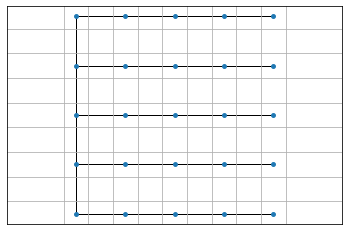

In [117]:
# Step 1: Define grid parameters
grid_lims  = np.array([[0,10], [0,10]]) # [m]
resolution = 1 # [m]
rmax, cmax = ((grid_lims[:,1]-grid_lims[:,0])/resolution).astype(int)

# Step 2: Define macro-grid -- one macro grid square holds a 2x2 base grid squares
        # Define nodes at the center of macro grid squares
ROWMAX, COLUMNMAX = ((grid_lims[:,1]-grid_lims[:,0])/resolution/2).astype(int)
macro_graph = nx.grid_2d_graph(ROWMAX,COLUMNMAX)

pos = dict( ( (i,j), (2*i+1/2, 2*(COLUMNMAX-1-j)+1/2) ) for
               (i,j) in np.ndindex(ROWMAX, COLUMNMAX))
for (i,j) in np.ndindex(ROWMAX, COLUMNMAX):
    this_pos = pos[i,j]
    macro_graph.nodes[(i,j)]["pos"] = this_pos
    


# Step 3: Find minimum spanning tree
tree = nx.minimum_spanning_tree(macro_graph)
nx.relabel_nodes(tree,pos,False)

plt.figure()
nx.draw_networkx(tree, pos=nx.get_node_attributes(tree,'pos'), 
                 with_labels=False, node_size = 15)
plt.xlim([0,rmax])
plt.ylim([0,cmax])
plt.xticks(range(rmax))
plt.axis('equal')
plt.grid('on')
plt.show()


## Create a path in the original grid that circumnavigates this spanning tree.

Below we prove that by circumnavigating the spanning tree of this macro-grid, we are guaranteed to cover every cell that is accessible from the starting cell. Because we have no obstacles in our environment, this is equivalent to covering all cells in the grid.

In order to circumnavigate the spanning tree, the robot must pass through each cell that is in contact with the tree. We defined our spanning tree nodes such that every grid cell is touching one node, the node of the macro-cell it is a part of. Therefore, since every cell is touching the spanning tree, and every cell touching the spanning tree is reached through circumnavigation, we can guarantee that the robot will reach every cell in the grid.

### Finding the circumnavigating path

To find the path that circumnavigates the spanning tree, we first create a graph out of the original grid. We do this as we did with the macro graph, by defining nodes in the center of each cell and drawing edges between nodes in adjacent cells. This is performed by the function nx.grid_2d_graph().

###### Proof of completeness
In order to circumnavigate the spanning tree, we want to guarantee that we will stay on one side of the path. That is, the robot should never make a movement that intersects with one of the spanning tree's edges. To this end, we remove all edges that intersect with the spanning tree from our grid.

###### Proof of optimality
In my implementation, the robot follows the tree CCW, in a single direction. Assume that the picar passes through a cell in the path twice before completing the loop and returning to its start cell. This implies that there must be a cell that is adjacent to two parallel edges of the spanning tree, such that the robot is able to reach the cell twice while following the tree. However, because the spanning tree was constructed from the macro-grid in which all macro cells are two small cells apart, all edges of the spanning tree are two cells. Thus, one small grid cell cannot be touching two paralel edges of the tree, and therefore the picar will not visit the cell more than once.

(-0.45636242783875175,
 9.456362427838751,
 -0.4597964534603297,
 9.459796453460328)

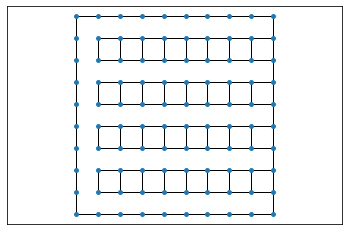

In [113]:
grid = nx.grid_2d_graph(rmax,cmax)
for i,j in np.ndindex(rmax,cmax):
    grid.nodes[(i,j)]["pos"] = (i,cmax-1-j)
    
G = copy.deepcopy(grid.edges)
for edge in G:
    for path in tree.edges:
        # Intersection test
        if np_seg_intersect(np.array(edge), np.array(path)) is not None:
            grid.remove_edge(*edge)
            
nx.draw_networkx(grid, pos=nx.get_node_attributes(grid,'pos'), 
                 with_labels=False, node_size = 15)

plt.axis('equal')

Finally, we create the picar's waypoints. We do ths by choosing a starting point -- I chose (x,y,h)=(0,0,0). we will then follow the spanning tree as though we were in a labyrinth and tracing the wall on our left. At each cell, the picar will examine the neighboring cells and decide which is the best choice. It will ignore cells it has already passed through, and it is biased toward turning left to keep it's "hand on the wall of the labyrinth" so to speak.

We first move one step in the opposite direction of our bias so that the remaining bias will turn us inward -- in practice, this just means we move one step forward before beginning the algorithm so we have a path to our left to trace. We then follow the aforementioned algorithm until we are in a cell where all adjacent cells have already been passed through. Once at this point, our path is complete.

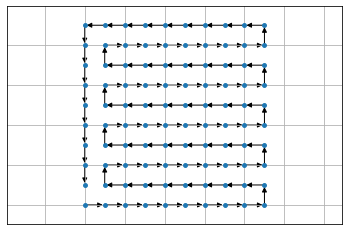

In [115]:
path = nx.DiGraph()
path.add_node((0,0), pos=(0,0))

my_pos = (0,0)
my_heading = 0
bias = pi/3

# Negative bias for first step -- first find the wall, then bias left turns
goal_pos, goal_heading = best_move(my_pos, my_heading, path, grid, bias=-bias)
path.add_node(goal_pos, pos=goal_pos)
path.add_edge(my_pos, goal_pos)
my_pos = goal_pos
my_heading = goal_heading

# Keep hand on same side of "wall"
neighbors = list(grid.neighbors(my_pos))
while( True ):
    move = best_move(my_pos, my_heading, path, grid, bias=bias)
    if move is None:
        break
    else:
        goal_pos, goal_heading = move
    
    # picar.to_waypoint(goal)
    path.add_node(goal_pos, pos=goal_pos)
    path.add_edge(my_pos, goal_pos)
    my_pos = goal_pos
    my_heading = goal_heading
    

nx.draw_networkx(path, pos=nx.get_node_attributes(path,'pos'), 
                 with_labels=False, node_size = 15)
plt.axis('equal')
plt.grid('on')

The path nodes can now be used as waypoints in the picar control loop.

## Picar Control Loop

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
from math import pi, sin, cos, tan
from time import sleep
import copy

# Find SunFounder_PiCar submodule
sys.path.append("../lib")
sys.path.append("../lib/SunFounder_PiCar")

# Custom libraries
from helpers import sign, angle_a2b, within_pi, clip
from my_pid import myPID
import perspectives 
from cartesian_pose import CartesianPose
from bicycle_model  import BicyclePose, next_pose, dXdt, dYdt, dHdt
from my_picar_utils import PicarHardwareInterface as Hardware 
from my_picar_utils import MyPicarController as Controller
from my_picar_utils import HardwareUnitConverter as Converter 
from my_picar_utils import MyWorldFrame as World 
from my_picar import Picar

In [9]:
def rotmat(theta):
    return np.array([[cos(theta), -sin(theta)], [sin(theta),cos(theta)]])

WIDTH=.8
HEIGHT=1.2
dims = np.array([HEIGHT,WIDTH])
def plot_wp_rects(ax, allposes):
    for pose in allposes:
        xy = pose[:2]
        th = pose[2]
        correction = np.matmul(rotmat(th), dims)/2
        r = mpl.patches.Rectangle(xy, HEIGHT, WIDTH, angle=th*180/pi, zorder=0)
        r.set_xy(xy-correction)
        ax.add_patch(r)
    
def to_cartesian(xyh):
    return CartesianPose(x=xyh[0],y=xyh[1],h=xyh[2])


def dist(a,b):
    a = np.array(a)
    b = np.array(b)
    if np.ndim(a)==1:
        a = a[None]
    if np.ndim(b)==1:
        b = b[None]
    return np.squeeze(np.sqrt(np.sum(np.power(a-b,2),axis=1)))

# while ( dist(picar.world_pose, goal) )

In [110]:
rhoPID   = myPID(Kp=0.04, Kd=0.01, Ki=0)
alphaPID = myPID(Kp=.075, Kd=0.01, Ki=0)
betaPID  = myPID(Kp=0.01, Kd=0, Ki=0)
controller = Controller(rhoPID, alphaPID, betaPID)

units = Converter(speed_slope=1/83, angle_slope=-1.2) # Left and right are switched in hardware
picar    = Picar(unit_converter=units, virtual=True)
picar_start = np.array([0,0,0])
dt = 0.01



In [111]:
my_pos = (0,0)
my_heading = 0
picar.set_pose(world_pose=to_cartesian([my_pos[0], my_pos[1], my_heading]))


actual_path = [picar.world_pose()]
for node in path:
    goal_pos = list(path.neighbors(my_pos))[0]
    goal_heading = atan2(goal_pos[1]-my_pos[1], goal_pos[0]-my_pos[0])
    picar.set_pose(goal_pose=to_cartesian([goal_pos[0], goal_pos[1], goal_heading]))
    i=0
    while (picar.rho()>0.1):
         # Calculate controls
        speed = controller.SPEED(rho=picar.rho(), dt=dt)
        steer = controller.STEER(speed=speed, alpha=picar.alpha(), beta=picar.beta(), L=picar.L)

        # Apply controls -- outputs are potentially adjusted if controls tried to go over max speed/steer
        speed, steer = picar.drive(speed=speed, steer=steer, direction=direction)

        # Update state via odometry
        picar.set_pose(world_pose=picar.next_pose(speed=picar._current_speed, steer=picar._current_steer, direction=1, dt=dt))
        my_pos = goal_pos
        my_heading = goal_heading
        if i % 50 ==0:
            actual_path.append(picar.world_pose())
        i+=1
    print("Waypoint reached: {}", picar.goal_pose())
    
    

Waypoint reached: {} CartesianPose: ( 1.000,  0.000,  0.000)
Waypoint reached: {} CartesianPose: ( 2.000,  0.000,  0.000)
Waypoint reached: {} CartesianPose: ( 3.000,  0.000,  0.000)
Waypoint reached: {} CartesianPose: ( 4.000,  0.000,  0.000)
Waypoint reached: {} CartesianPose: ( 5.000,  0.000,  0.000)
Waypoint reached: {} CartesianPose: ( 6.000,  0.000,  0.000)
Waypoint reached: {} CartesianPose: ( 7.000,  0.000,  0.000)
Waypoint reached: {} CartesianPose: ( 8.000,  0.000,  0.000)
Waypoint reached: {} CartesianPose: ( 9.000,  0.000,  0.000)
Waypoint reached: {} CartesianPose: ( 9.000,  1.000,  1.571)


KeyboardInterrupt: 

#### Commentary
My control loop isn't properly tuned right now and my picar broke in transit so... I tried! You can see below that the simulation does well until it has to turn at (9,0), where it starts to loop out of control...

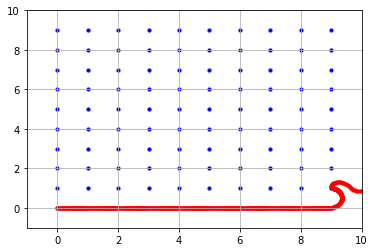

In [112]:
plt.figure()
for node in path:
    plt.scatter(node[0], node[1], marker='o', c='b', s=10)
[plt.scatter(pt.x, pt.y,c='r',marker='.') for i,pt in enumerate(actual_path) if i<2000];
plt.xlim([-1,10])
plt.ylim([-1,10])
plt.grid('on')

